In [ ]:
###Load packages###
import pandas as pd
import os
import ast
from scipy import stats
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
import numpy as np
import seaborn as sns
from doctest import debug



###Load cleaned dataset###

#Set file paths
topdir = '/Users/sm6511/Desktop/Prediction-Accomodation-Exp'
study = 'Study1.0'
cleandir = os.path.join(topdir, f'data/{study}/Cleaned')
outputdir = os.path.join(topdir, f'Analysis/{study}')
debug = 0

#Read in cleaned data (from cleaning scripts)
accomodate_path = os.path.join(cleandir, f'{study}Accomodate.csv')
predict_path   = os.path.join(cleandir, f'{study}Predict.csv')

df_accommodate = pd.read_csv(accomodate_path)
df_predict   = pd.read_csv(predict_path)

df_accommodate['task'] = 'accommodate'
df_predict['task']   = 'predict'



print("Accomodate columns:", df_accommodate.columns.tolist())
print("Predict columns:", df_predict.columns.tolist())


Accomodate columns: ['participant', 'free_texts', 'feedback', 'food_amount', 'trial_stop_time', 'testing_image_order', 'testing_responses', 'training_categories', 'training_tail', 'training_shape', 'training_color', 'testing_categories', 'conditionOrder', 'training_image_order', 'attention_check', 'relevant_dim_1', 'relevant_dim_2', 'irrelevant_dim', 'color_high', 'color_low', 'shape_high', 'shape_low', 'tail_high', 'tail_low', 'shape_discrete_slider.response', 'shape_direction_slider.response', 'shape_continuous_slider.response', 'color_discrete_slider.response', 'color_direction_slider.response', 'color_continuous_slider.response', 'tail_discrete_slider.response', 'tail_direction_slider.response', 'tail_continuous_slider.response', 'task']
Predict columns: ['participant', 'training_responses', 'food_amount', 'error', 'feedback', 'trial_stop_time', 'testing_image_order', 'testing_responses', 'training_categories', 'training_tail', 'training_shape', 'training_color', 'testing_categorie

In [43]:
#Converting string representations of lists back to lists

def parse_list_column(x):
    """take column entries that are strings representing lists and convert them to actual lists"""
    if pd.isna(x):
        return []
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        x = x.strip()
        if x.startswith('[') and x.endswith(']'):
            return ast.literal_eval(x)
        else:
            return [x]
    return []
for col in ['training_tail', 'training_shape', 'training_color', 'training_image_order', 'training_categories', 'testing_categories']:
    df_accommodate[col] = df_accommodate[col].apply(parse_list_column)
    df_predict[col]   = df_predict[col].apply(parse_list_column)

df_accommodate['testing_responses'] = df_accommodate['testing_responses'].apply(ast.literal_eval)
df_accommodate['food_amount'] = df_accommodate['food_amount'].apply(ast.literal_eval)
df_accommodate['testing_image_order'] = df_accommodate['testing_image_order'].apply(ast.literal_eval)
df_accommodate['free_texts'] = df_accommodate['free_texts'].apply(ast.literal_eval)
df_predict['testing_responses'] = df_predict['testing_responses'].apply(ast.literal_eval)
df_predict['food_amount'] = df_predict['food_amount'].apply(ast.literal_eval)
df_predict['testing_image_order'] = df_predict['testing_image_order'].apply(ast.literal_eval)
#Combine the dataframes and create an arbitrary column for participant numbering (the yoked orders are already stored in 'conditionOrder')
df_combined = pd.concat([df_accommodate, df_predict], ignore_index=True)
df_combined['participant'] = range(1, len(df_combined) + 1)



In [44]:
#Create map from short codes to feature descriptions

shape_map = {
    'square': 's',
    'circular': 'c'
}

color_map = {
    'blue': 'b',
    'yellow': 'y'
}

tail_map = {
    'curly': 't',
    'straight': 'n'
}


feature_maps = {
    'shape': shape_map,
    'color': color_map,
    'tail': tail_map
}


In [45]:
#Compute featuer importance scores


def compute_feature_importance_from_df(df):
    """
    Compute numeric feature importance scores(-7 to 7) for each participant,
    based on the saved slider_responses and the feature _high/_low mapping.
    This is computed based on whether a feature was really relevant (positive sign) or irrelevant (negative sign).
    0 = no response or feature was not thought to be relevant
    columns:
      - shape_discrete_slider.response, shape_direction_slider.response, shape_continuous_slider.response
      - color_discrete_slider.response, ...
      - tail_discrete_slider.response, ...
      - shape_high, shape_low, color_high, color_low, tail_high, tail_low
    """
    features = ['shape', 'color', 'tail']
    
    def compute_row_importance(row, feat):
        disc = row[f'{feat}_discrete_slider.response']
        dirc = row[f'{feat}_direction_slider.response']
        cont = row[f'{feat}_continuous_slider.response']

        #If they said a feature wasn't relevant, then importance is 0
        
        if disc == 'No' or pd.isna(disc):
            return 0.0
        
        # Make sure continuous slider value exists, if not, set it to 0
        cont_val = float(cont) if not pd.isna(cont) else 0.0

        # Get mapping from long to short feature name
        mapping = feature_maps.get(feat, {})

        # Normalize strings: strip whitespace, collapse multiple spaces, lower-case
        def normalize_str(s):
            """Strip leading/trailing whitespace and collapse internal multiple spaces."""

            if isinstance(s, str):
                return " ".join(s.split()).lower()
            return ""

        #Name of features need to be normalized for comparison using the mapping
        dirc_norm = normalize_str(dirc)

        #Get internal short code for selected feature direction
        internal_dirc = mapping.get(dirc_norm, None)
        
        #Normalize high and low feature values from the dataframe
        high_val = normalize_str(row[f'{feat}_high']).lower()
        low_val  = normalize_str(row[f'{feat}_low']).lower()
        
        # Debug print statement (make sure mappings look right)
        debug = False
        if debug:
            print('response:', repr(dirc_norm), 'internal:', repr(internal_dirc), 
                'high:', repr(high_val), 'low:', repr(low_val))
            

        #If they correctly selected the high feature, assign positive sign
        if internal_dirc == high_val:
            sign = 1
        #If they incorrectly selected the low feature, assign negative sign
        elif internal_dirc == low_val:
            if debug:
                print('in negative')
            sign = -1
        else:
            if debug:
                print('in empty')
            sign = 0
            cont_val = 0.0

        # Add sign to continuous value
        importance = cont_val * sign

        return importance

    
    # Compute for each feature
    for feat in features:
        df[f'{feat}_importance'] = df.apply(lambda row: compute_row_importance(row, feat), axis=1)
    
    return df

df_combined = compute_feature_importance_from_df(df_combined)
if debug:
    print(df_combined['tail_importance'])

In [46]:

#Define importance raint columns
importance_cols = [f"{feat}_importance" for feat in ['tail', 'color', 'shape']]
#Get relevant columns
cols_needed = ['task', 'training_image_order', 'food_amount', 'conditionOrder',
                'color_high', 'tail_high', 'shape_high', 'irrelevant_dim', 'relevant_dim_1', 'relevant_dim_2'] + importance_cols
#Copy overarching data frame
df_sub = df_combined[cols_needed].copy()
df_long = df_sub.explode(['training_image_order', 'food_amount']).rename(columns={'training_image_order': 'item'})
#print(df_long.head(30))
   # Mean food amount per item
df_items = (
    df_long.groupby(['task', 'conditionOrder', 'item'], as_index=False)
            .agg(
                food_amount=('food_amount', 'mean'),
                color_high=('color_high', 'first'),
                tail_high=('tail_high', 'first'),
                shape_high=('shape_high', 'first'),
                **{f"{feat}_importance": (f"{feat}_importance", 'first') for feat in ['tail', 'color', 'shape']}))
df_items[['tail_val', 'color_val', 'shape_val']] = (
    df_items['item'].str.split('_', expand=True)
)
#print(df_items)
df_long_feat = df_items.melt(
    id_vars=['task', 'conditionOrder', 'food_amount',
             'tail_high', 'color_high', 'shape_high'],
    value_vars=['tail_val', 'color_val', 'shape_val'],
    var_name='feature',
    value_name='feature_value'
)
df_long_feat['feature'] = df_long_feat['feature'].str.replace('_val', '')
df_long_feat['high_or_low'] = df_long_feat.apply(
    lambda r: (
        'high'
        if r['feature_value'] == r[f"{r['feature']}_high"]
        else 'low'
    ),
    axis=1
)
hl = (
    df_long_feat
    .groupby(['task', 'conditionOrder', 'feature', 'high_or_low'])
    .agg(food_mean=('food_amount', 'mean'))
    .unstack()
)
hl['high_minus_low'] = (
    hl['food_mean']['high'] - hl['food_mean']['low']
)
df_hl = (
    hl.reset_index()
      [['task', 'conditionOrder', 'feature', 'high_minus_low']]
)
importance_long = (
    df_items
    .groupby(['task', 'conditionOrder'], as_index=False)
    .agg(
        tail_importance=('tail_importance', 'first'),
        color_importance=('color_importance', 'first'),
        shape_importance=('shape_importance', 'first')
    )
    .melt(
        id_vars=['task', 'conditionOrder'],
        var_name='feature',
        value_name='importance'
    )
)

importance_long['feature'] = importance_long['feature'].str.replace('_importance', '')
#print(importance_long)
#print(df_hl)
df_hl.columns = df_hl.columns.get_level_values(0)
df_hl_full = df_hl.merge(
    importance_long,
    on=['task', 'conditionOrder', 'feature'],
    how='left'
)
df_hl_full['high_minus_low'] = pd.to_numeric(
    df_hl_full['high_minus_low'], errors='coerce'
)

df_hl_full = df_hl_full.dropna(subset=['high_minus_low'])
print(df_hl_full)


            task  conditionOrder feature  high_minus_low  importance
0    accommodate               1   color        1.166667         4.0
1    accommodate               1   shape        0.500000         3.0
2    accommodate               1    tail        3.000000         6.0
3    accommodate               2   color        2.083333         6.0
4    accommodate               2   shape        1.916667         4.0
..           ...             ...     ...             ...         ...
895      predict             149   shape        1.916667        -1.0
896      predict             149    tail        0.416667         3.0
897      predict             150   color        2.500000         6.0
898      predict             150   shape        0.500000         3.0
899      predict             150    tail        2.500000         5.0

[900 rows x 5 columns]


In [47]:
bins = [0, 1.5, 2.5, df_hl_full['high_minus_low'].max()+1] 
labels = ['0.0-1.5', '1.5-2.5', '2.5+']
df_hl_full['hl_bin'] = pd.cut(df_hl_full['high_minus_low'], bins=bins, labels=labels, include_lowest=True)
avg_importance_by_bin = (
    df_hl_full.groupby(['task', 'hl_bin'], as_index=False)
               .agg(avg_importance=('importance', 'mean'),
                    n_items=('importance', 'size'))
)

print(avg_importance_by_bin)

          task   hl_bin  avg_importance  n_items
0  accommodate  0.0-1.5        1.127854      219
1  accommodate  1.5-2.5        2.541899      179
2  accommodate     2.5+        3.692308       52
3      predict  0.0-1.5        1.013699      219
4      predict  1.5-2.5        2.379888      179
5      predict     2.5+        3.865385       52


/var/folders/t5/wz7tq5fx44j9z9q48fv6hc0c0000gq/T/ipykernel_65382/3943281512.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_hl_full.groupby(['task', 'hl_bin'], as_index=False)


/var/folders/t5/wz7tq5fx44j9z9q48fv6hc0c0000gq/T/ipykernel_65382/3644324083.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_hl_full.groupby(['feature', 'hl_bin_dynamic'], as_index=False)


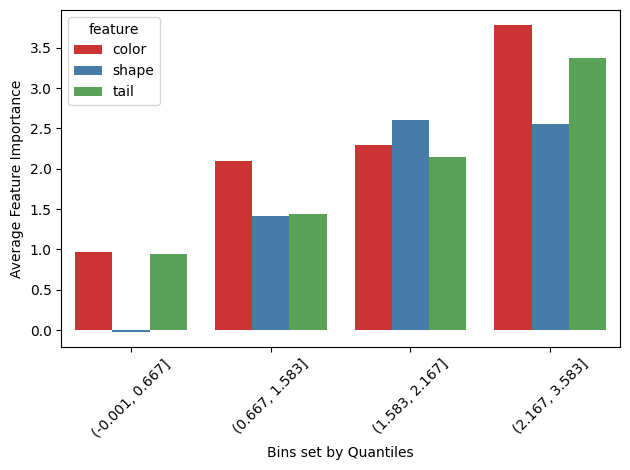

In [48]:
import seaborn as sns
# Create quantile-based bins
df_hl_full['hl_bin_dynamic'] = pd.qcut(df_hl_full['high_minus_low'], q=4, duplicates='drop')
avg_dyn = (
    df_hl_full.groupby(['feature', 'hl_bin_dynamic'], as_index=False)
               .agg(avg_importance=('importance', 'mean'),
                    n_items=('importance', 'size'))
)

sns.barplot(
    data=avg_dyn,
    x='hl_bin_dynamic',
    y='avg_importance',
    hue='feature',
    palette='Set1'
)
plt.xlabel('Bins set by Quantiles')
plt.ylabel('Average Feature Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<Figure size 700x500 with 0 Axes>

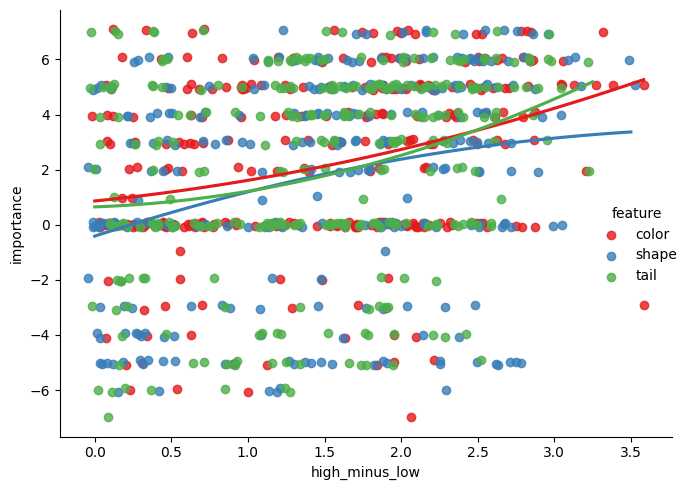

In [49]:
# Scatter with regression lines per task
plt.figure(figsize=(7,5))
sns.lmplot(
    data=df_hl_full,
    x='high_minus_low',
    y='importance',
    hue='feature',       # color by task
    height=5,
    aspect=1.2,
    ci=None,       
    markers='o',
    palette='Set1',
    x_jitter=0.05, 
    y_jitter=0.1,
    order=2
)

plt.tight_layout()
#plt.savefig(os.path.join(outputdir, 'Figure6_SupplementaryIrrelevantFeatureImportanceVsActualAmount.png'), dpi=300)
plt.show()

/var/folders/t5/wz7tq5fx44j9z9q48fv6hc0c0000gq/T/ipykernel_65382/2996842031.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_hl_full.groupby(['task', 'hl_bin_dynamic'], as_index=False)


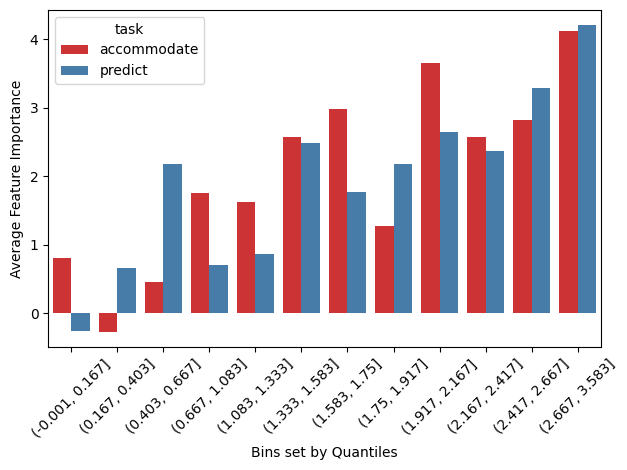

In [50]:
# Create quantile-based bins
df_hl_full['hl_bin_dynamic'] = pd.qcut(df_hl_full['high_minus_low'], q=12, duplicates='drop')
avg_dyn = (
    df_hl_full.groupby(['task', 'hl_bin_dynamic'], as_index=False)
               .agg(avg_importance=('importance', 'mean'),
                    n_items=('importance', 'size'))
)

sns.barplot(
    data=avg_dyn,
    x='hl_bin_dynamic',
    y='avg_importance',
    hue='task',
    palette='Set1'
)
plt.xlabel('Bins set by Quantiles')
plt.ylabel('Average Feature Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


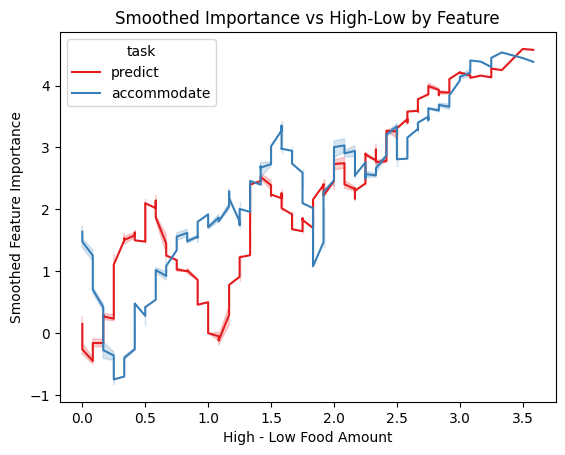

In [51]:
df_hl_full = df_hl_full.sort_values('high_minus_low')

df_hl_full['rolling_mean'] = (
    df_hl_full.groupby('task')['importance']
               .transform(lambda x: x.rolling(window=50, min_periods=1, center=True).mean())
)

sns.lineplot(
    data=df_hl_full,
    x='high_minus_low',
    y='rolling_mean',
    hue='task',
    palette='Set1'
)
plt.xlabel('High - Low Food Amount')
plt.ylabel('Smoothed Feature Importance')
plt.title('Smoothed Importance vs High-Low by Feature')
plt.show()


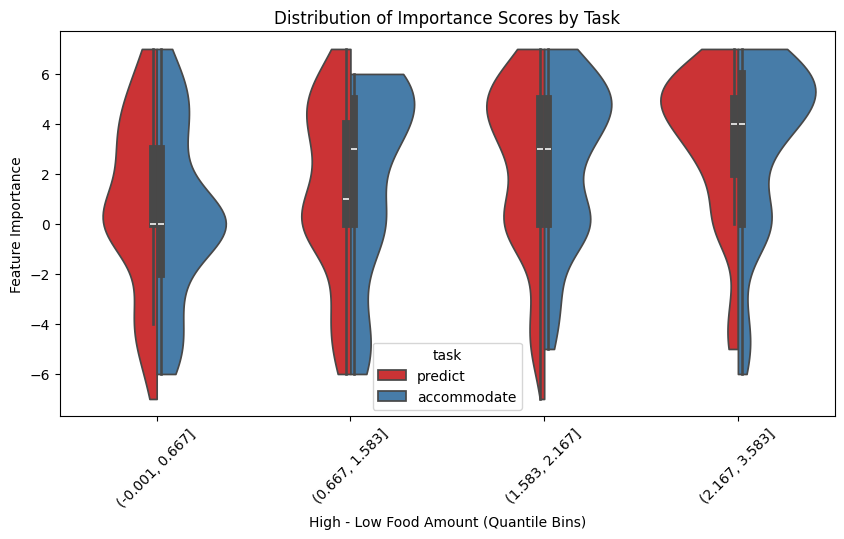

In [52]:
# Bin high-low into quantiles for violin plot
df_hl_full['hl_bin'] = pd.qcut(df_hl_full['high_minus_low'], q=4, duplicates='drop')

plt.figure(figsize=(10,5))
sns.violinplot(
    data=df_hl_full,
    x='hl_bin',
    y='importance',
    hue='task',
    split=True,      # split the violins by task
    palette='Set1',
    cut = 0
)
plt.xlabel('High - Low Food Amount (Quantile Bins)')
plt.ylabel('Feature Importance')
plt.title('Distribution of Importance Scores by Task')
plt.xticks(rotation=45)
plt.show()


<Figure size 700x500 with 0 Axes>

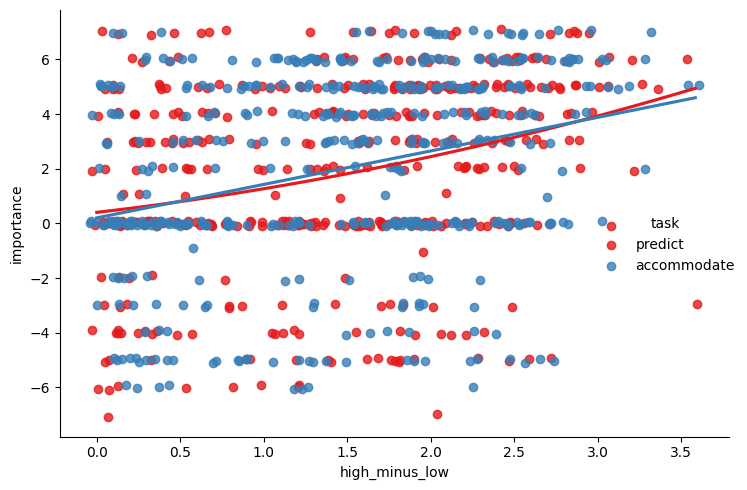

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter with regression lines per task
plt.figure(figsize=(7,5))
sns.lmplot(
    data=df_hl_full,
    x='high_minus_low',
    y='importance',
    hue='task',       # color by task
    height=5,
    aspect=1.2,
    ci=None,       
    markers='o',
    palette='Set1',
    x_jitter=0.05, 
    y_jitter=0.1,
    order=2
)

plt.tight_layout()
#plt.savefig(os.path.join(outputdir, 'Figure6_SupplementaryIrrelevantFeatureImportanceVsActualAmount.png'), dpi=300)
plt.show()

In [23]:
print(df_accommodate['irrelevant_dim'])

0      shape
1      shape
2      color
3      color
4      shape
       ...  
145    color
146    color
147    color
148    shape
149     tail
Name: irrelevant_dim, Length: 150, dtype: object


In [54]:
import pandas as pd

def compute_high_minus_low(df, dim_col, importance_prefix=''):
    """
    Compute high_minus_low and feature importance for a given dimension.

    Parameters:
    - df: DataFrame with columns for task, conditionOrder, items, high/low features, and importances
    - dim_col: str, the column name that specifies the dimension ('irrelevant_dim', 'relevant_dim_1', etc.)
    - importance_prefix: str, prefix for importance columns (default '') e.g., 'relevant_' or 'irrelevant_'

    Returns:
    - final_df: DataFrame with columns ['task', 'conditionOrder', dim_col, 'high_minus_low', f'{importance_prefix}importance']
    """

    # Relevant columns
    importance_cols = [f"{feat}_importance" for feat in ['tail', 'color', 'shape']]
    cols_needed = ['task', 'training_image_order', 'food_amount', 'conditionOrder',
                   'color_high', 'tail_high', 'shape_high', dim_col] + importance_cols
    df_sub = df[cols_needed]

    # Explode lists into rows
    df_long = df_sub.explode(['training_image_order', 'food_amount']).rename(columns={'training_image_order': 'item'})

    # Mean food amount per item
    df_items = (
        df_long.groupby(['task', 'conditionOrder', 'item'], as_index=False)
               .agg(
                   food_amount=('food_amount', 'mean'),
                   color_high=('color_high', 'first'),
                   tail_high=('tail_high', 'first'),
                   shape_high=('shape_high', 'first'),
                   **{dim_col: (dim_col, 'first')},
                   **{f"{feat}_importance": (f"{feat}_importance", 'first') for feat in ['tail', 'color', 'shape']}
               )
    )

    # Extract the value of the specified dimension from the item
    def get_dim_value(row):
        tail, color, shape = row['item'].split('_')
        dim = row[dim_col]
        if dim == 'tail':
            return tail
        elif dim == 'color':
            return color
        elif dim == 'shape':
            return shape

    df_items['dim_value'] = df_items.apply(get_dim_value, axis=1)

    # Determine high vs low for that dimension
    df_items['high_or_low'] = df_items.apply(
        lambda row: 'high' if row['dim_value'] == row[f"{row[dim_col]}_high"] else 'low',
        axis=1
    )

    # Get importance for this dimension
    df_items[f'{importance_prefix}importance'] = df_items.apply(
        lambda row: row[f"{row[dim_col]}_importance"], axis=1
    )

    # Group and compute high_minus_low
    agg = (
        df_items.groupby(['task', 'conditionOrder', dim_col, 'high_or_low'])
                .agg(
                    food_amount_mean=('food_amount', 'mean'),
                    importance_mean=(f'{importance_prefix}importance', 'mean')
                )
                .unstack(fill_value=0)
    )

    # Compute high_minus_low
    agg['high_minus_low'] = agg['food_amount_mean']['high'] - agg['food_amount_mean']['low']

    # Get importance (just pick high, should equal low)
    agg[f'{importance_prefix}importance'] = agg['importance_mean']['high']

    # Reset index and select final columns
    final_df = agg.reset_index()[['task', 'conditionOrder', dim_col, 'high_minus_low', f'{importance_prefix}importance']]

    # Ensure numeric
    final_df['high_minus_low'] = pd.to_numeric(final_df['high_minus_low'], errors='coerce')
    final_df[f'{importance_prefix}importance'] = pd.to_numeric(final_df[f'{importance_prefix}importance'], errors='coerce')

    return final_df
# For irrelevant dimension
df_irrelevant = compute_high_minus_low(df_combined, dim_col='irrelevant_dim', importance_prefix='irrelevant_')

# For relevant dimension 1
df_relevant = compute_high_minus_low(df_combined, dim_col='relevant_dim_1', importance_prefix='relevant_')

print(df_irrelevant.head())
print(df_relevant.head())


                    task conditionOrder irrelevant_dim high_minus_low  \
high_or_low                                                             
0            accommodate              1          shape       0.500000   
1            accommodate              2           tail       0.750000   
2            accommodate              3          color       0.333333   
3            accommodate              4           tail       1.083333   
4            accommodate              5          color       0.666667   

            irrelevant_importance  
high_or_low                        
0                             3.0  
1                             0.0  
2                             0.0  
3                             3.0  
4                             4.0  
                    task conditionOrder relevant_dim_1 high_minus_low  \
high_or_low                                                             
0            accommodate              1          color       1.166667   
1            acco

<Figure size 700x500 with 0 Axes>

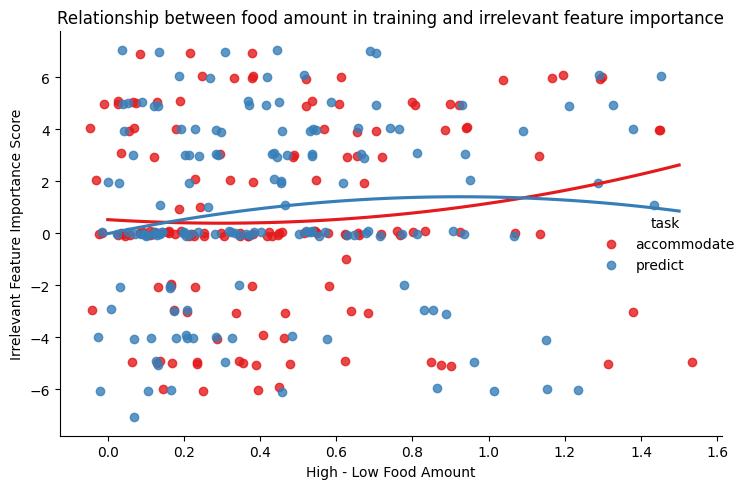

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter with regression lines per task
plt.figure(figsize=(7,5))
sns.lmplot(
    data=df_irrelevant,
    x='high_minus_low',
    y='irrelevant_importance',
    hue='task',       # color by task
    height=5,
    aspect=1.2,
    ci=None,       
    markers='o',
    palette='Set1',
    x_jitter=0.05, 
    y_jitter=0.1,
    order = 2
)

plt.xlabel('High - Low Food Amount')
plt.ylabel('Irrelevant Feature Importance Score')
plt.title('Relationship between food amount in training and irrelevant feature importance')
plt.tight_layout()
plt.savefig(os.path.join(outputdir, 'Figure6_SupplementaryIrrelevantFeatureImportanceVsActualAmount.png'), dpi=300)
plt.show()

          task  conditionOrder irrelevant_dim  high_minus_low  \
0  accommodate               1          shape        0.500000   
1  accommodate               2           tail        0.750000   
2  accommodate               3          color        0.333333   
3  accommodate               4           tail        1.083333   
4  accommodate               5          color        0.666667   

   irrelevant_importance                        hl_bin_dynamic  
0                    3.0               (0.5, 0.58333333333333]  
1                    0.0  (0.68333333333333, 0.91666666666667]  
2                    0.0                         (0.25, 0.375]  
3                    3.0               (0.91666666666667, 1.5]  
4                    4.0  (0.58333333333333, 0.68333333333333]  


/var/folders/t5/wz7tq5fx44j9z9q48fv6hc0c0000gq/T/ipykernel_65382/2394829847.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_irrelevant.groupby(['task', 'hl_bin_dynamic'], as_index=False)


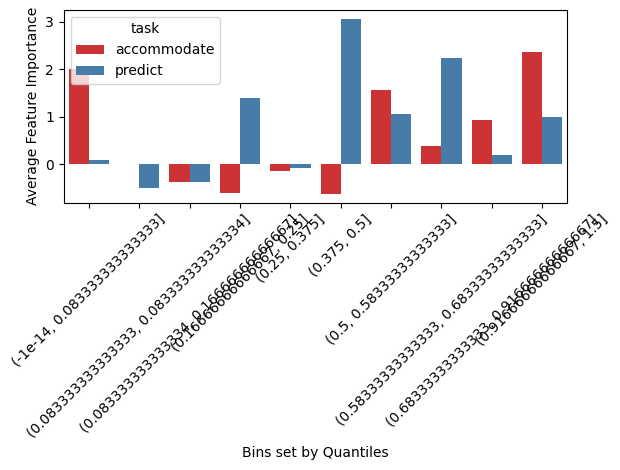

In [70]:
# Create quantile-based bins
df_irrelevant['hl_bin_dynamic'] = pd.qcut(df_irrelevant['high_minus_low'], q=10, duplicates='drop')
print(df_irrelevant.head())
df_irrelevant.columns = df_irrelevant.columns.get_level_values(0)
avg_dyn = (
    df_irrelevant.groupby(['task', 'hl_bin_dynamic'], as_index=False)
               .agg(avg_importance=('irrelevant_importance', 'mean'),
                    n_items=('irrelevant_importance', 'size'))
)

sns.barplot(
    data=avg_dyn,
    x='hl_bin_dynamic',
    y='avg_importance',
    hue='task',
    palette='Set1'
)
plt.xlabel('Bins set by Quantiles')
plt.ylabel('Average Feature Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [62]:
import statsmodels.formula.api as smf

model = smf.ols(
    "irrelevant_importance ~ high_minus_low * task",
    data=df_irrelevant
).fit()

summary_df = model.summary2().tables[1]
summary_df.to_csv(os.path.join(outputdir, "supplementaryIrrelevantScores.csv"))
print(model.summary())


                              OLS Regression Results                             
Dep. Variable:     irrelevant_importance   R-squared:                       0.011
Model:                               OLS   Adj. R-squared:                  0.001
Method:                    Least Squares   F-statistic:                     1.107
Date:                   Tue, 20 Jan 2026   Prob (F-statistic):              0.347
Time:                           09:51:00   Log-Likelihood:                -800.71
No. Observations:                    300   AIC:                             1609.
Df Residuals:                        296   BIC:                             1624.
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

<Figure size 700x500 with 0 Axes>

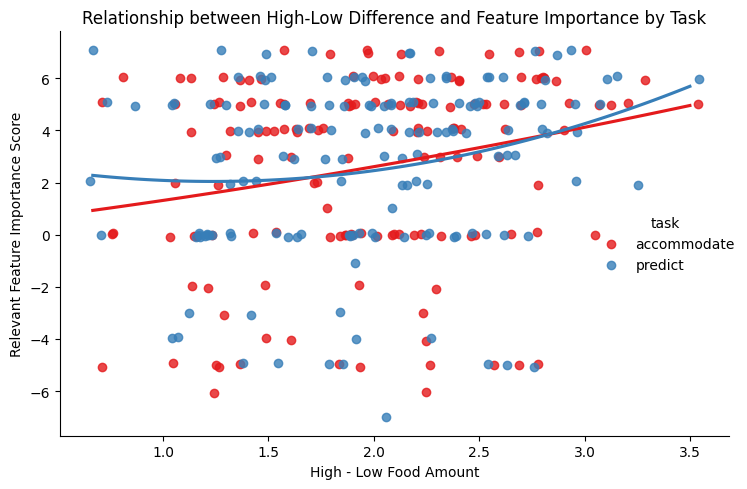

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter with regression lines per task
plt.figure(figsize=(7,5))
sns.lmplot(
    data=df_relevant,
    x='high_minus_low',
    y='relevant_importance',
    hue='task',       # color by task
    height=5,
    aspect=1.2,
    ci=None,          
    markers='o',
    palette='Set1',
    x_jitter=0.05, 
    y_jitter=0.1,
    order=2
)

plt.xlabel('High - Low Food Amount')
plt.ylabel('Relevant Feature Importance Score')
plt.title('Relationship between High-Low Difference and Feature Importance by Task')
plt.savefig(os.path.join(outputdir, 'Figure7_SupplementaryRelevantFeatureImportanceVsActualAmount.png'), dpi=300)
plt.tight_layout()
plt.show()


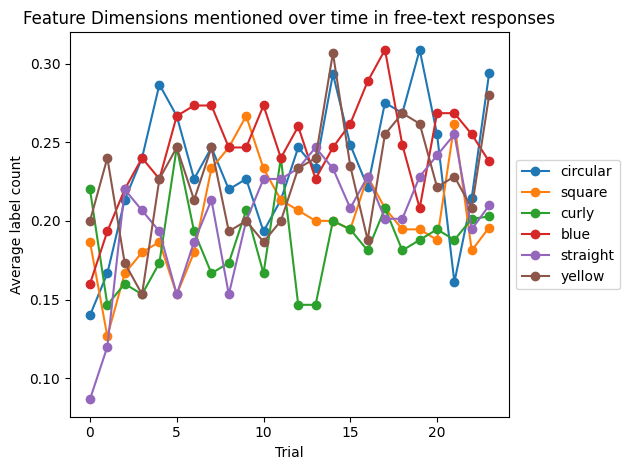

In [33]:
def count_labels_over_time(free_text_list, word_labels):
    """
    free_text_list: list of free-text responses (strings) in order
    word_labels: dict mapping label -> list of words
    Returns a list of dicts (one per trial) with counts per label
    """
    counts_over_time = []

    for text in free_text_list:
        text_lower = text.lower()  # lowercase 
        counts = {label: 0 for label in word_labels}

        for label, words in word_labels.items():
            for word in words:
                counts[label] += text_lower.count(word)  # count occurrences
        counts_over_time.append(counts)

    return counts_over_time


word_labels = {
    'circular': ['circle', 'circular', 'oval', 'round'],
    'square': ['square', 'squared', 'rectangle', 'rectangular'],
    'curly': ['curly'],
    'straight': ['straight'],
    'blue': ['blue'],
    'yellow': ['yellow']
}

all_counts = []

for idx, row in df_accommodate.iterrows():
    participant_id = row['participant'] 
    free_text_list = row['free_texts']
    
    counts = count_labels_over_time(free_text_list, word_labels)
    
    # Add participant ID and timepoint
    for trial, count_dict in enumerate(counts):
        count_dict.update({'participant': participant_id, 'trial': trial})
        all_counts.append(count_dict)

# Convert to DataFrame for analysis
df_counts = pd.DataFrame(all_counts)
df_grouped = df_counts.groupby('trial')[['circular','square','curly', 'blue', 'straight', 'yellow']].mean()
df_grouped.plot(marker='o')
plt.xlabel('Trial')
plt.ylabel('Average label count')
plt.title('Feature Dimensions mentioned over time in free-text responses')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout() 
plt.show()
plt.show()


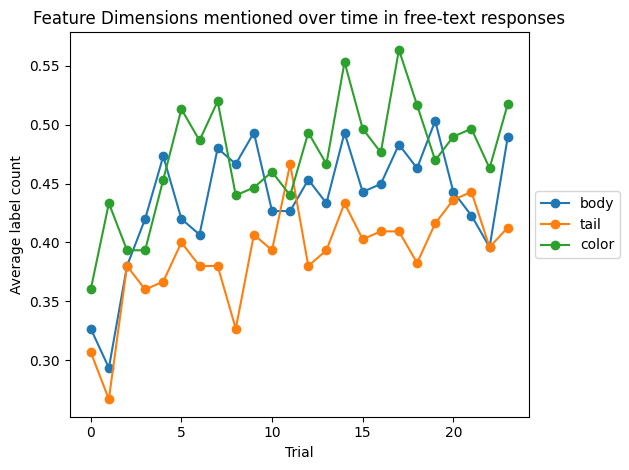

In [35]:
word_labels = {
    'body': ['circle', 'circular', 'oval', 'round', 'square', 'squared', 'rectangle', 'rectangular'],
    'tail': ['curly', 'straight'],
    'color': ['blue', 'yellow']
}

all_counts = []

for idx, row in df_accommodate.iterrows():
    participant_id = row['participant'] 
    free_text_list = row['free_texts']
    
    counts = count_labels_over_time(free_text_list, word_labels)
    
    # Add participant ID and timepoint
    for trial, count_dict in enumerate(counts):
        count_dict.update({'participant': participant_id, 'trial': trial})
        all_counts.append(count_dict)

# Convert to DataFrame for analysis
df_counts = pd.DataFrame(all_counts)
df_grouped = df_counts.groupby('trial')[['body', 'tail', 'color']].mean()
df_grouped.plot(marker='o')
plt.xlabel('Trial')
plt.ylabel('Average label count')
plt.title('Feature Dimensions mentioned over time in free-text responses')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout() 
plt.show()
plt.show()

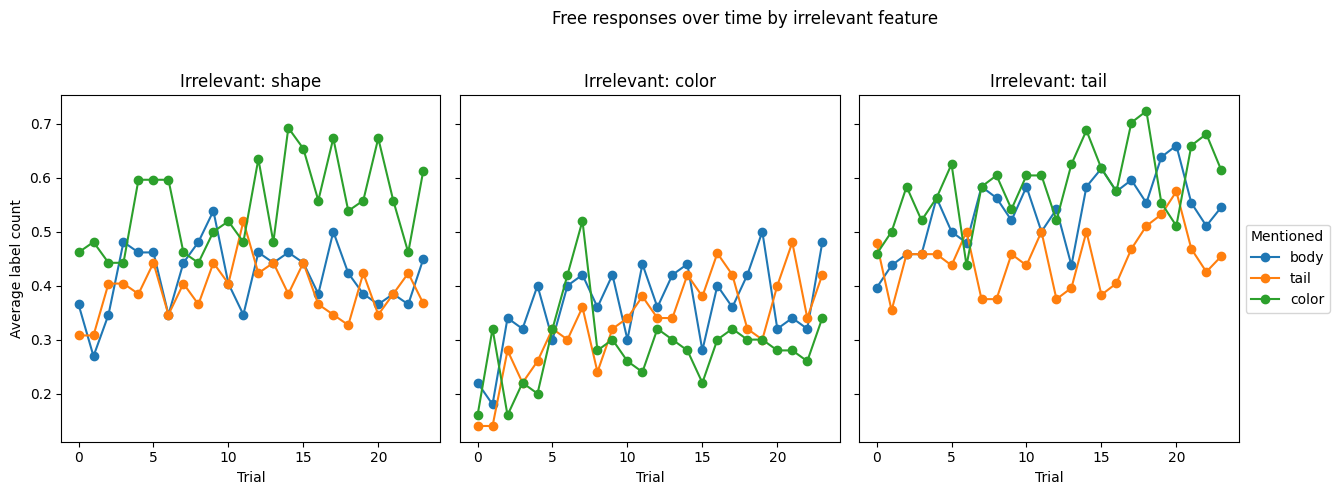

In [ ]:
def analyze_free_text_labels(df, word_labels, task_name='accommodate'):
    """
    df: DataFrame with columns ['participant', 'free_texts', 'irrelevant_dim']
    word_labels: dict mapping label -> list of words
    task_name: just for plot titles
    """
    all_counts = []

    for idx, row in df.iterrows():
        participant_id = row['participant']
        free_text_list = row['free_texts']
        irrelevant_feature = row['irrelevant_dim']

        counts = count_labels_over_time(free_text_list, word_labels)
        
        # Add participant ID, trial, and irrelevant_dim
        for trial, count_dict in enumerate(counts):
            count_dict.update({
                'participant': participant_id,
                'trial': trial,
                'irrelevant_dim': irrelevant_feature
            })
            all_counts.append(count_dict)

    # Convert to DataFrame
    df_counts = pd.DataFrame(all_counts)

    # Plot per irrelevant feature
    labels = list(word_labels.keys())
    irr_feats = df_counts['irrelevant_dim'].unique()
    fig, axes = plt.subplots(1, len(irr_feats), figsize=(15,5), sharey=True)

    for ax, irr_feat in zip(axes, irr_feats):
        df_grouped = df_counts[df_counts['irrelevant_dim'] == irr_feat] \
                        .groupby('trial')[labels].mean()
        df_grouped.plot(ax=ax, marker='o', legend=False)
        ax.set_title(f'Irrelevant: {irr_feat}')
        ax.set_xlabel('Trial')
        ax.set_ylabel('Average label count')

    plt.suptitle('Free responses over time by irrelevant feature')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Mentioned')
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # leave space for suptitle
    plt.show()

    return df_counts
df_counts = analyze_free_text_labels(df_accommodate, word_labels)


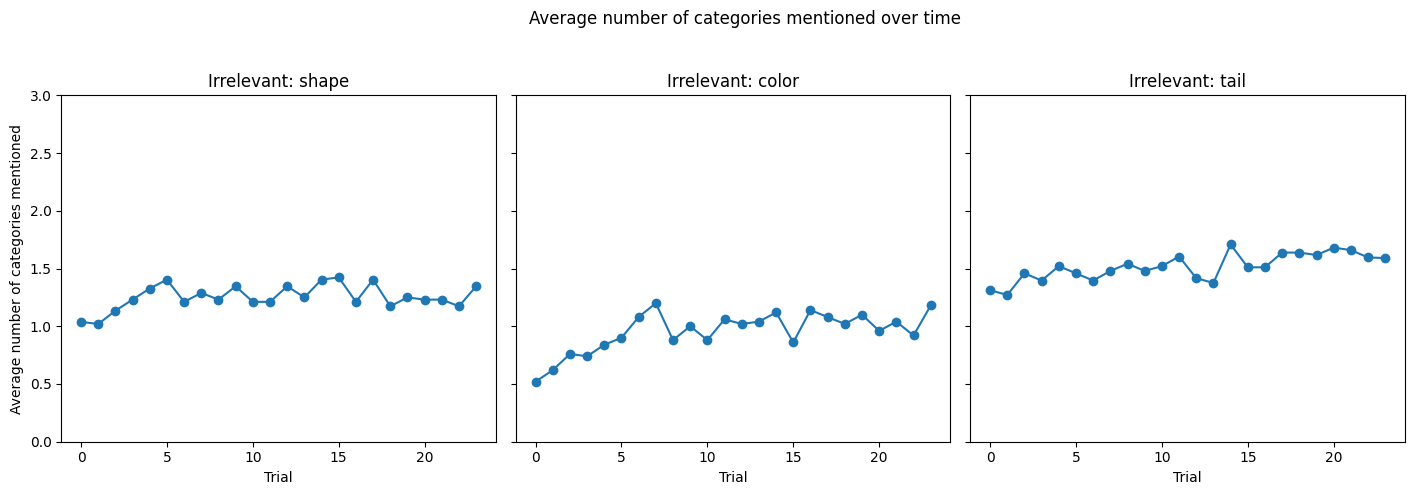

In [36]:
def analyze_free_text_num_mentions(df, word_labels, task_name='accommodate'):
    """
    df: DataFrame with columns ['participant', 'free_texts', 'irrelevant_dim']
    word_labels: dict mapping label -> list of words
    Returns: df_counts with number of categories mentioned per trial and plots 0-3 mentions over time
    """
    all_counts = []

    for idx, row in df.iterrows():
        participant_id = row['participant']
        free_text_list = row['free_texts']
        irrelevant_feature = row['irrelevant_dim']

        counts = count_labels_over_time(free_text_list, word_labels)
        
        # Convert counts into number of categories mentioned (0-3)
        for trial, count_dict in enumerate(counts):
            num_mentions = sum([1 for lbl in word_labels if count_dict[lbl] > 0])
            all_counts.append({
                'participant': participant_id,
                'trial': trial,
                'irrelevant_dim': irrelevant_feature,
                'num_mentions': num_mentions
            })

    df_counts = pd.DataFrame(all_counts)

    # Plot per irrelevant feature (0-3 mentions)
    irr_feats = df_counts['irrelevant_dim'].unique()
    fig, axes = plt.subplots(1, len(irr_feats), figsize=(15,5), sharey=True)

    for ax, irr_feat in zip(axes, irr_feats):
        df_grouped = df_counts[df_counts['irrelevant_dim'] == irr_feat] \
                        .groupby('trial')['num_mentions'].mean()
        df_grouped.plot(ax=ax, marker='o', linestyle='-')
        ax.set_title(f'Irrelevant: {irr_feat}')
        ax.set_xlabel('Trial')
        ax.set_ylabel('Average number of categories mentioned')
        ax.set_ylim(0, 3)  # 0-3 mentions possible

    plt.suptitle('Average number of categories mentioned over time')
    plt.tight_layout(rect=[0, 0, 0.95, 0.95])
    plt.show()

    return df_counts
df_counts = analyze_free_text_num_mentions(df_accommodate, word_labels)

In [ ]:
#Group by average food amount per item in training
df = df_combined[['task', 'training_image_order', 'food_amount', 'conditionOrder', 'color_high', 'tail_high', 'shape_high', 'irrelevant_dim', 
                  'tail_importance', 'color_importance', 'shape_importance']]
df_long3 = (
    df
    .explode(['training_image_order', 'food_amount'])
    .rename(columns={'training_image_order': 'item'})
)
avg_food_extended = (
    df_long3
    .groupby(['task', 'conditionOrder', 'item'], as_index=False)
    .agg(
        food_amount=('food_amount', 'mean'),
        color_high=('color_high', 'first'),
        tail_high=('tail_high', 'first'),
        shape_high=('shape_high', 'first'),
        irrelevant_dim=('irrelevant_dim', 'first')
    )
)

avg_food_train_extended = avg_food_extended.copy()

df = avg_food_train_extended.copy()

#print(df)
df['high_or_low'] = df.apply(
    lambda row: 'high' if row[f"{row['irrelevant_dim']}_high"] == row[f"{row['irrelevant_dim']}_high"] else 'low',
    axis=1
)
def get_irrelevant_value(row):
    tail, color, shape = row['item'].split('_')
    if row['irrelevant_dim'] == 'tail':
        return tail
    elif row['irrelevant_dim'] == 'color':
        return color
    elif row['irrelevant_dim'] == 'shape':
        return shape
    else:
        return None

df['irrelevant_value'] = df.apply(get_irrelevant_value, axis=1)

# Quick check
#print(df[['item', 'irrelevant_dim', 'irrelevant_value', 'tail_high', 'color_high', 'shape_high']].head(20))
df['high_or_low'] = df.apply(
    lambda row: 'high' if row['irrelevant_value'] == row[f"{row['irrelevant_dim']}_high"] else 'low',
    axis=1
)

# Debug
#print(df[['item', 'irrelevant_dim', 'irrelevant_value', 'high_or_low']].head(20))
# Compute high vs low difference
high_low_diff = (
    df.groupby(['task', 'conditionOrder', 'irrelevant_dim', 'high_or_low'])['food_amount']
      .mean()             # average food amount per high/low
      .unstack(fill_value=0)  # columns become 'high' and 'low'; missing = 0
)

# Compute high_minus_low
high_low_diff['high_minus_low'] = high_low_diff['high'] - high_low_diff['low']

# Reset index for a clean table
high_low_diff = high_low_diff.reset_index()

print(high_low_diff[['task', 'conditionOrder', 'irrelevant_dim', 'high_minus_low']])



In [ ]:
import pandas as pd

# Get Relevant Columns
df = df_combined[['task', 'training_image_order', 'food_amount', 'conditionOrder',
                  'color_high', 'tail_high', 'shape_high', 'irrelevant_dim',
                  'tail_importance', 'color_importance', 'shape_importance']]

# Explode lists into rows
df_long = df.explode(['training_image_order', 'food_amount']).rename(columns={'training_image_order': 'item'})

# 3️Compute mean food amount per item
df_items = (
    df_long.groupby(['task', 'conditionOrder', 'item'], as_index=False)
           .agg(
               food_amount=('food_amount', 'mean'),
               color_high=('color_high', 'first'),
               tail_high=('tail_high', 'first'),
               shape_high=('shape_high', 'first'),
               irrelevant_dim=('irrelevant_dim', 'first'),
               tail_importance=('tail_importance', 'first'),
               color_importance=('color_importance', 'first'),
               shape_importance=('shape_importance', 'first')
           )
)

# Extract actual value of the irrelevant dimension from the item
def get_irrelevant_value(row):
    tail, color, shape = row['item'].split('_')
    if row['irrelevant_dim'] == 'tail':
        return tail
    elif row['irrelevant_dim'] == 'color':
        return color
    elif row['irrelevant_dim'] == 'shape':
        return shape

df_items['irrelevant_value'] = df_items.apply(get_irrelevant_value, axis=1)

# Determine if each item is high or low along the irrelevant dimension
df_items['high_or_low'] = df_items.apply(
    lambda row: 'high' if row['irrelevant_value'] == row[f"{row['irrelevant_dim']}_high"] else 'low',
    axis=1
)

# Get importance for irrelevant feature for each item
df_items['irrelevant_importance'] = df_items.apply(
    lambda row: row[f"{row['irrelevant_dim']}_importance"], axis=1
)

# Compute high vs low differences and keep importance score
agg = (
    df_items.groupby(['task', 'conditionOrder', 'irrelevant_dim', 'high_or_low'])
            .agg(
                food_amount_mean=('food_amount', 'mean'),
                irrelevant_importance_mean=('irrelevant_importance', 'mean')
            )
            .unstack(fill_value=0)  # separate 'high' and 'low'
)

# Compute high_minus_low
agg['high_minus_low'] = agg['food_amount_mean']['high'] - agg['food_amount_mean']['low']

# Get irrelevant importance
agg['irrelevant_importance'] = agg['irrelevant_importance_mean']['high']

# Reset index and select final columns
final_df = agg.reset_index()[['task', 'conditionOrder', 'irrelevant_dim', 'high_minus_low', 'irrelevant_importance']]
final_df['high_minus_low'] = pd.to_numeric(final_df['high_minus_low'], errors='coerce')
final_df['irrelevant_importance'] = pd.to_numeric(final_df['irrelevant_importance'], errors='coerce')

print(final_df.head(10))


In [ ]:
# Position-based decoding
FEATURE_INDEX = {
    "tail":  0,  # T or N
    "color": 1,  # B or Y
    "shape": 2   # S or C
}
def extract_feature(stimulus, feature):
    """
    stimulus: string like 'T_B_S'
    feature: 'tail', 'color', or 'shape'
    """
    return stimulus.split("_")[FEATURE_INDEX[feature]]
mapping = {
    "tail":  {"T": 1, "N": 0},
    "shape": {"S": 1, "C": 0},
    "color": {"B": 1, "Y": 0}
}
cols_to_keep = [
    "participant",
    "task",
    "conditionOrder",
    "irrelevant_dim",
    "food_amount",
    "training_color",
    "training_shape",
    "training_tail",
    "training_image_order",
    "tail_importance",
    "shape_importance",
    "color_importance"
]

def compute_true_irrelevant_assoc(row):
    irrel_feat = row["irrelevant_dim"]

    # Food values
    food = np.array(
        ast.literal_eval(row["food_amount"])
        if isinstance(row["food_amount"], str)
        else row["food_amount"],
        dtype=float
    )

    # Extract irrelevant feature value per training trial
    irrel_vals = np.array([
        mapping[irrel_feat][
            extract_feature(stim, irrel_feat)
        ]
        for stim in row["training_image_order"]
    ])

    mean_high = food[irrel_vals == 1].mean()
    mean_low  = food[irrel_vals == 0].mean()

    return mean_high - mean_low
df_irrel_truth = df_combined[cols_to_keep].copy()

df_irrel_truth["true_irrelevant_assoc"] = df_irrel_truth.apply(
    compute_true_irrelevant_assoc,
    axis=1
)

df_irrel_truth[
    ["task", "conditionOrder", "irrelevant_dim", "true_irrelevant_assoc", "color_importance", "shape_importance", "tail_importance"]
]

In [ ]:
def get_irrelevant_importance(row):
    return row[f"{row['irrelevant_dim']}_importance"]

df_plot = df_irrel_truth.copy()
df_plot["irrelevant_importance"] = df_plot.apply(
    get_irrelevant_importance, axis=1
)

plt.figure(figsize=(9, 4))

sns.scatterplot(
    data=df_plot,
    x="true_irrelevant_assoc",
    y="irrelevant_importance",
    hue="task",
    style="task",
    s=60
)

for task, sub in df_plot.groupby("task"):
    sns.regplot(
        data=sub,
        x="true_irrelevant_assoc",
        y="irrelevant_importance",
        scatter=False,
        ci=None,
        label=f"{task} fit"
    )

plt.axhline(0, color="gray", linestyle="--")
plt.axvline(0, color="gray", linestyle="--")

plt.xlabel("True irrelevant association")
plt.ylabel("Irrelevant dimension rating")
plt.title("Irrelevant Dimension Rating vs True Association")
plt.legend(
    title="Task",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)
plt.tight_layout()
plt.show()


